In [1]:
import matplotlib.pyplot as plt      
from mpl_toolkits import mplot3d
import os
import sys
import glob
import time
import shutil
import gym
from gym import error, spaces, utils
import numpy as np
import math
from pathlib import Path

In [2]:
import gym_fish
from gym_fish.envs.lib import pyflare as fl
from gym_fish.envs.fish_env_hierachy import FishEnvLowLevel,FishEnvHighLevel

In [3]:
Experiment_name = 'test HighLevel with t_diff '
Experiment_note = """
"""

In [4]:
gpuId =0

control_dt = 0.2
radius=1.0

theta = np.array([-180,180])
random_vel = np.array([0.1,0.5])
max_time = 10

action_max= 2
couple_mode =  fl.COUPLE_MODE.TWO_WAY

wp= np.array([0.0,1.0])
wv = 1.0
wa= 0.5
live_penality=-0.1

use_com=False
ratio = 0.005/control_dt*(max_time/10)
import torch
torch.cuda.set_device(gpuId)

In [5]:
num_train_steps= int(2e6*ratio)
replay_buffer_capacity=int(2e6*ratio)
num_seed_steps=int(2048*ratio)

eval_frequency=int(20000*ratio)
num_eval_episodes=1
device="cuda"
# logger
log_frequency=1
log_save_tb=True
# video recorder
seed=1

In [6]:

discount=0.99
alpha_lr=3e-4
alpha_betas=[0.9, 0.999]
actor_lr=3e-4
actor_betas=[0.9, 0.999]
critic_lr=3e-4
critic_betas=[0.9, 0.999]
critic_tau=0.005
batch_size=int(2048*ratio)
# batch_size = 256
gradient_steps=1
target_update_interval=2
ent_coef= "auto"
target_entropy= "auto" 

# critic settings
critic_net_arch= [128,128]
n_critics = 2
# actor settings
actor_net_arch= [128,128]
actor_log_std_bounds=[-20, 2]

evaluate_save_data = False
evaluate_save_fluid = False



In [7]:
os.chdir(Path(os.getcwd()+"/../").resolve())
print(os.getcwd())

/root/pytorch_fish


### Import Settings

In [8]:
cwd = os.getcwd()+"/"
data_folder =cwd+ 'py_data/'
json_folder =data_folder+'jsons/'
path_folder =json_folder+'paths/'
scripts_folder = cwd+'scripts/'

In [9]:
fluid_json = json_folder+'fluid_param_test.json'
rigid_json = json_folder+'rigids_4_30_new.json'
path_json = str(Path("./py_data/jsons/paths/line.json").resolve())
print(fluid_json)
print(rigid_json)
print(path_json)

/root/pytorch_fish/py_data/jsons/fluid_param_test.json
/root/pytorch_fish/py_data/jsons/rigids_4_30_new.json
/root/pytorch_fish/py_data/jsons/paths/line.json


In [10]:
def plot_infos(infos,title,reward_fig_name):
    dd = {k:[] for k in infos[0].keys()}
    for info in infos:
        for k in info.keys():
            dd[k].append(info[k])
    plt.figure()
    for k in dd.keys():
        if k=='action_penality':
            plt.plot(np.arange(0,len(dd[k])),[kkk  for kkk in dd[k]],label=k)
        else:
            plt.plot(np.arange(0,len(dd[k])),dd[k],label=k)
    plt.legend()
    plt.title(title)
    plt.savefig(reward_fig_name)
    plt.show()

### Output Settings

In [11]:
store_folder_name = time.strftime('%Y-%m-%d/',time.localtime(time.time()))+Experiment_name+'_'+time.strftime('%Y-%m-%d %H:%M/',time.localtime(time.time()))
imgs_folder_name = 'imgs/'
rl_data_folder_name = 'rl_data/'
rl_data_all_name='collected_o_a.npz'
network_folder_name = 'networks/'
store_folder = cwd+'output_data/'+store_folder_name
imgs_folder = store_folder+imgs_folder_name
rl_data_folder= store_folder+rl_data_folder_name
network_folder = store_folder+network_folder_name

if not os.path.exists(store_folder):
    os.makedirs(store_folder)
if not os.path.exists(imgs_folder):
    os.makedirs(imgs_folder)
if not os.path.exists(rl_data_folder):
    os.makedirs(rl_data_folder)
if not os.path.exists(network_folder):
    os.makedirs(network_folder)

## Saving sources

In [12]:
save_sources = True
sources_folder_name = ['py_data','scripts']
if save_sources==True:
    for fn in sources_folder_name:
        shutil.copytree(cwd+fn,store_folder+'sources/'+fn)
with open(store_folder+'note.txt','w+') as f:
    f.write(time.strftime('%Y-%m-%d %H:%M\n',time.localtime(time.time())))
    f.write(Experiment_note)

### RL_TRAINING Setup

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import math
import os
import sys
import time
import pickle as pkl

from sac.logger import Logger
from sac.agent.replay_buffer import ReplayBuffer

## RL Begin

In [14]:
from sac.agent.sac import SACAgent
from sac.agent.critic import Critic
from sac.agent.actor import DiagGaussianActor

In [15]:
algo = 'SAC'
algofoler=algo+'/'
if not os.path.exists(network_folder+algofoler):
    os.makedirs(network_folder+algofoler)
if not os.path.exists(network_folder+algofoler+'imgs/'):
    os.makedirs(network_folder+algofoler+'imgs/')
if not os.path.exists(network_folder+algofoler+'imgs/trajs/'):
    os.makedirs(network_folder+algofoler+'imgs/trajs/')
if not os.path.exists(network_folder+algofoler+'imgs/rewards/'):
    os.makedirs(network_folder+algofoler+'imgs/rewards/')
if not os.path.exists(network_folder+algofoler+'models/'):
    os.makedirs(network_folder+algofoler+'models/')

tb_folder =  network_folder+algofoler
model_folder = network_folder+algofoler+'models/'
result_img_folder = network_folder+algofoler+'imgs/'

In [16]:
ll_env=FishEnvLowLevel(gpuId=gpuId,
                    couple_mode=couple_mode,control_dt=control_dt,max_time=max_time,radius = radius,
                    theta=theta,action_max=action_max,random_vel=random_vel,
                    rigid_json=rigid_json,use_com=use_com,
                    wv=wv,wp=wp,wa=wa,live_penality =live_penality,
                    fluid_json=fluid_json
                   )

print(ll_env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd())


[1. 0. 0.]


In [17]:
# agent settings
ll_obs_dim=ll_env.observation_space.shape[0] # to be specified later
ll_action_dim=ll_env.action_space.shape[0] # to be specified later
ll_action_space = ll_env.action_space

logger = Logger(tb_folder,save_tb=log_save_tb,
                             agent="sac")
ll_critic_network = Critic(ll_obs_dim, ll_action_dim,
                           net_arch=critic_net_arch,n_critics= n_critics)
ll_critic_target_network = Critic(ll_obs_dim, ll_action_dim,
                                  net_arch=critic_net_arch,n_critics= n_critics)

ll_actor_network = DiagGaussianActor( ll_obs_dim, ll_action_dim, 
                                     actor_net_arch,actor_log_std_bounds)

ll_replay_buffer = ReplayBuffer(ll_env.observation_space.shape,ll_env.action_space.shape,
                                int(replay_buffer_capacity),'cpu')

ll_agent = SACAgent(ll_obs_dim,
                    ll_action_dim,
                    ll_action_space,'cpu',
                    ll_critic_network,
                   ll_critic_target_network,
                    ll_actor_network,
                    ll_replay_buffer, 
                 discount,ent_coef,target_entropy,
                 alpha_lr,alpha_betas,actor_lr,actor_betas,critic_lr,critic_betas,critic_tau,
                 gradient_steps,target_update_interval,batch_size)


ll_agent_path = '/root/pytorch_fish/output_data/2021-05-05/test LowLevel _2021-05-05 07:30/networks/SAC/models/model'
ll_agent.load(ll_agent_path)

In [18]:
hl_env = FishEnvHighLevel(ll_env = ll_env,
                 ll_actor=ll_agent,
                 traj_json=Path("./py_data/jsons/paths/path_ss.json").resolve(),
                 wc = 0.3,
                          wt = 200.0,
                 live_penality = -0.1,
                 max_time=20)
hl_env.reset()

/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([ 0.12658023,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.13999999,  0.        ,
        0.        ,  0.83999996,  0.        ,  0.        ,  1.53931753,
        0.        ,  0.        ,  2.22964087,  0.        , -0.00229841,
        0.13999999,  0.        ,  0.        ])

In [19]:
# agent settings
hl_obs_dim=hl_env.observation_space.shape[0] # to be specified later
hl_action_dim=hl_env.action_space.shape[0] # to be specified later
hl_action_space = hl_env.action_space

logger = Logger(tb_folder,save_tb=log_save_tb,
                             agent="sac")
hl_critic_network = Critic(hl_obs_dim, hl_action_dim,
                           net_arch=critic_net_arch,n_critics= n_critics)
hl_critic_target_network = Critic(hl_obs_dim, hl_action_dim,
                                  net_arch=critic_net_arch,n_critics= n_critics)

hl_actor_network = DiagGaussianActor( hl_obs_dim, hl_action_dim, 
                                     actor_net_arch,actor_log_std_bounds)

hl_replay_buffer = ReplayBuffer(hl_env.observation_space.shape,hl_env.action_space.shape,
                                int(replay_buffer_capacity),device)

hl_agent = SACAgent(hl_obs_dim,
                    hl_action_dim,
                    hl_action_space,device,
                    hl_critic_network,
                   hl_critic_target_network,
                    hl_actor_network,
                    hl_replay_buffer, 
                 discount,ent_coef,target_entropy,
                 alpha_lr,alpha_betas,actor_lr,actor_betas,critic_lr,critic_betas,critic_tau,
                 gradient_steps,target_update_interval,batch_size)


In [20]:
step = 0
next_eval_steps= eval_frequency

In [21]:
 def collect_traj(seed_steps=False):
        obs = hl_env.reset()
        done = False
        reward = 0
        samples = []
        while not done:
            if seed_steps:
                action = hl_env.action_space.sample()
            else:
                action = hl_agent.predict(obs, deterministic=False)
            next_obs, reward, done, _ = hl_env.step(action)
            action = hl_agent.scale_action(action)
            samples.append((obs,action,next_obs,reward,done))
            obs = next_obs
            if done:
                if (not np.isfinite(obs).all()):
                    print('bad observation, try new traj')
                    samples.clear()
                    obs = hl_env.reset()
                    done = False
                    reward = 0 
        return samples

In [22]:
def collect_seed_samples():
        step = 0 
        while step<num_seed_steps:
            samples = collect_traj(seed_steps=True)
            for sample in samples:
                obs,action,next_obs,reward,done = sample
                hl_agent.replay_buffer.add(obs, action, reward, next_obs,done)
                step+=1
                if step>=num_seed_steps:
                    break
        print("Collect seed samples complete. Step: ",step," Seed steps:",num_seed_steps)

In [23]:
def evaluate():
        average_episode_reward = 0
        reward_fig_name =result_img_folder+'rewards/'+"steps_{0}.png".format(step)
        traj_fig_name =result_img_folder+'trajs/'+"steps_{0}.png".format(step)
        best_rewards = -9999
        for episode in range(num_eval_episodes):
            print("Evaluating episode " + str(episode) +" ....")
            obs = hl_env.reset()
            done = False
            episode_reward = 0
            infos = []
            while not done:
                action=hl_agent.predict(obs, deterministic=True)
                obs, reward, done, info = hl_env.step(action)
                infos.append(info)
                # video_recorder.record(hl_env)
                episode_reward += reward
            if episode_reward>best_rewards:
                best_rewards = episode_reward
                plot_infos(infos,title=str(step),reward_fig_name=reward_fig_name)
                hl_env.plot3d(title=str(step),fig_name = traj_fig_name)
            average_episode_reward += episode_reward
            # video_recorder.save(f'{step}.mp4')
        average_episode_reward /= num_eval_episodes
        logger.log('eval/episode_reward', average_episode_reward,step)
        logger.dump(step,ty='eval')

### RL Train

In [24]:
!./clean_visdata.sh

rm: cannot remove './data/vis_data/Objects/*': No such file or directory
rm: cannot remove './data/vis_data/Fluid/*': No such file or directory


In [25]:
collect_seed_samples()
episode, episode_reward= 0, 0
start_time = time.time()

Collect seed samples complete. Step:  51  Seed steps: 51


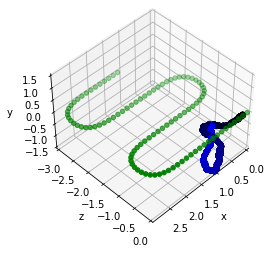

In [26]:
hl_env.plot3d()

| train | E: 1 | S: 51 | R: 114.2481 | D: 136.7 s | BR: 1.1000 | ALOSS: -3.7478 | CLOSS: 61.6341 | TLOSS: -0.0506 | TVAL: 0.9925 | AENT: -4.0000
| train | E: 2 | S: 104 | R: -5.9376 | D: 135.1 s | BR: 1.1887 | ALOSS: -6.1117 | CLOSS: 65.3748 | TLOSS: -0.1555 | TVAL: 0.9771 | AENT: -4.0000
| train | E: 3 | S: 157 | R: 111.0609 | D: 131.2 s | BR: 1.1636 | ALOSS: -6.6097 | CLOSS: 82.2776 | TLOSS: -0.2618 | TVAL: 0.9617 | AENT: -4.0000
| train | E: 4 | S: 213 | R: 34.5823 | D: 134.7 s | BR: 1.1793 | ALOSS: -7.2572 | CLOSS: 79.9518 | TLOSS: -0.3702 | TVAL: 0.9462 | AENT: -4.0000
| train | E: 5 | S: 266 | R: 105.1266 | D: 132.5 s | BR: 1.2671 | ALOSS: -8.2820 | CLOSS: 73.8109 | TLOSS: -0.4756 | TVAL: 0.9309 | AENT: -4.0000
| train | E: 6 | S: 318 | R: -4.1553 | D: 134.0 s | BR: 1.1920 | ALOSS: -8.6609 | CLOSS: 90.2855 | TLOSS: -0.5710 | TVAL: 0.9165 | AENT: -4.0000
| train | E: 7 | S: 372 | R: 5.4641 | D: 142.1 s | BR: 1.2761 | ALOSS: -9.5880 | CLOSS: 123.7345 | TLOSS: -0.6588 | TVAL: 0.9024

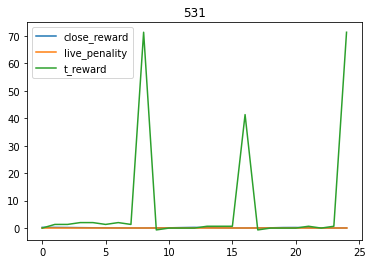

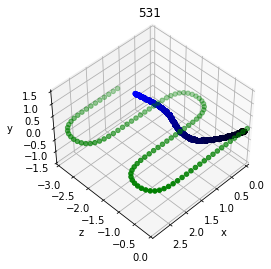

| eval  | E: 9 | S: 531 | R: 197.7551
| train | E: 10 | S: 531 | R: 106.0757 | D: 97.7 s | BR: 1.1789 | ALOSS: -11.3360 | CLOSS: 153.8598 | TLOSS: -0.8784 | TVAL: 0.8626 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 11 | S: 584 | R: -2.9496 | D: 190.9 s | BR: 1.0497 | ALOSS: -11.5738 | CLOSS: 106.7713 | TLOSS: -0.9549 | TVAL: 0.8501 | AENT: -4.0000
| train | E: 12 | S: 638 | R: 105.4590 | D: 129.0 s | BR: 0.8956 | ALOSS: -11.9064 | CLOSS: 103.0285 | TLOSS: -1.0559 | TVAL: 0.8376 | AENT: -4.0000
| train | E: 13 | S: 690 | R: 108.2924 | D: 130.4 s | BR: 0.8090 | ALOSS: -12.7542 | CLOSS: 109.0272 | TLOSS: -1.1278 | TVAL: 0.8252 | AENT: -4.0000
| train | E: 14 | S: 744 | R: 1.7236 | D: 134.4 s | BR: 0.9883 | ALOSS: -13.3915 | CLOSS: 110.6020 | TLOSS: -1.2069 | TVAL: 0.8130 | AENT: -4.0000
| train | E: 15 | S: 787 | R: 113.3627 | D: 99.7 s | BR: 1.2320 | ALOSS: -13.9617 | CLOSS: 109.1747 | TLOSS: -1.2882 | TVAL: 0.8021 | AENT: -4.0000
| train | E: 16 | S: 841 | R: 181.8281 | D: 139.9 s | BR: 1.1503 | ALOSS: -14.7884 | CLOSS: 111.1985 | TLOSS: -1.3748 | TVAL: 0.7911 | AENT: -4.0000
| train | E: 17 | S: 899 | R: -3.4517 | D: 135.0 s | BR: 1.4019 | ALOSS: -15.6665 | CLOSS: 119.5482 | TLOSS: -

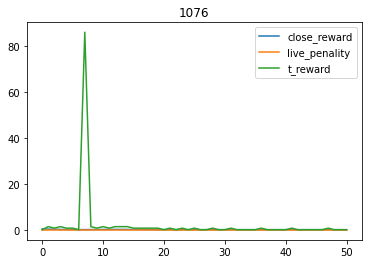

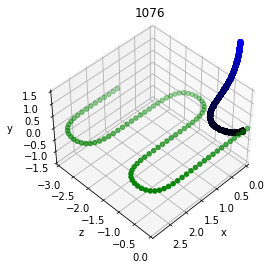

| eval  | E: 19 | S: 1076 | R: 104.2508
| train | E: 20 | S: 1076 | R: 106.4342 | D: 147.1 s | BR: 1.1305 | ALOSS: -17.3227 | CLOSS: 85.9053 | TLOSS: -1.7054 | TVAL: 0.7407 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 21 | S: 1134 | R: 98.9063 | D: 282.4 s | BR: 1.3120 | ALOSS: -17.8938 | CLOSS: 93.5564 | TLOSS: -1.8170 | TVAL: 0.7288 | AENT: -4.0000
| train | E: 22 | S: 1191 | R: 104.6875 | D: 131.9 s | BR: 1.3197 | ALOSS: -18.4602 | CLOSS: 92.5806 | TLOSS: -1.9240 | TVAL: 0.7169 | AENT: -4.0000
| train | E: 23 | S: 1245 | R: 106.8293 | D: 130.5 s | BR: 1.5085 | ALOSS: -19.1605 | CLOSS: 76.6527 | TLOSS: -2.0127 | TVAL: 0.7055 | AENT: -4.0000
| train | E: 24 | S: 1301 | R: 108.1538 | D: 141.5 s | BR: 1.5190 | ALOSS: -19.4489 | CLOSS: 80.3992 | TLOSS: -2.0938 | TVAL: 0.6944 | AENT: -4.0000
| train | E: 25 | S: 1357 | R: 109.4842 | D: 132.8 s | BR: 1.1307 | ALOSS: -20.3825 | CLOSS: 64.1437 | TLOSS: -2.1623 | TVAL: 0.6832 | AENT: -4.0000
| train | E: 26 | S: 1412 | R: 105.8978 | D: 133.2 s | BR: 1.6622 | ALOSS: -20.8657 | CLOSS: 81.8672 | TLOSS: -2.2694 | TVAL: 0.6724 | AENT: -4.0000
| train | E: 27 | S: 1464 | R: -5.0598 | D: 132.0 s | BR: 1.5794 | ALOSS: -21.4876 | CLOSS: 65.0603 | TLOSS

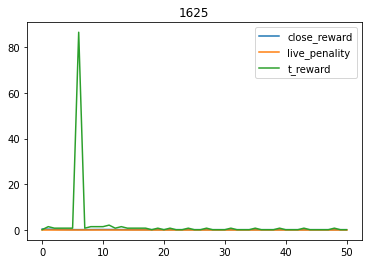

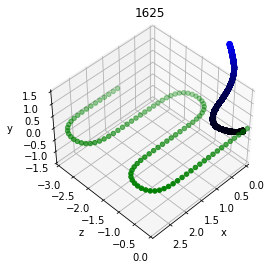

| eval  | E: 29 | S: 1625 | R: 104.4187
| train | E: 30 | S: 1625 | R: 106.9438 | D: 92.7 s | BR: 1.1413 | ALOSS: -22.5477 | CLOSS: 49.1637 | TLOSS: -2.5474 | TVAL: 0.6322 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 31 | S: 1681 | R: 108.7318 | D: 145.5 s | BR: 1.4928 | ALOSS: -23.0992 | CLOSS: 51.7794 | TLOSS: -2.6552 | TVAL: 0.6225 | AENT: -4.0000
| train | E: 32 | S: 1738 | R: 108.1449 | D: 58.8 s | BR: 1.6470 | ALOSS: -23.6385 | CLOSS: 49.0505 | TLOSS: -2.7110 | TVAL: 0.6125 | AENT: -4.0000
| train | E: 33 | S: 1794 | R: 101.4047 | D: 65.1 s | BR: 1.5215 | ALOSS: -24.2661 | CLOSS: 51.3207 | TLOSS: -2.8029 | TVAL: 0.6027 | AENT: -4.0000
| train | E: 34 | S: 1847 | R: 109.3335 | D: 59.8 s | BR: 0.7628 | ALOSS: -24.3425 | CLOSS: 52.0768 | TLOSS: -2.9238 | TVAL: 0.5934 | AENT: -4.0000
| train | E: 35 | S: 1898 | R: 111.3123 | D: 58.1 s | BR: 1.7084 | ALOSS: -25.1077 | CLOSS: 48.6176 | TLOSS: -2.9725 | TVAL: 0.5845 | AENT: -4.0000
| train | E: 36 | S: 1953 | R: 187.3167 | D: 59.5 s | BR: 1.4640 | ALOSS: -25.2664 | CLOSS: 37.0215 | TLOSS: -3.1028 | TVAL: 0.5756 | AENT: -4.0000
| train | E: 37 | S: 2005 | R: 116.0062 | D: 56.7 s | BR: 1.1064 | ALOSS: -25.2940 | CLOSS: 44.5517 | TLOSS: -3

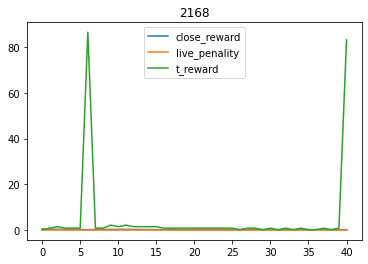

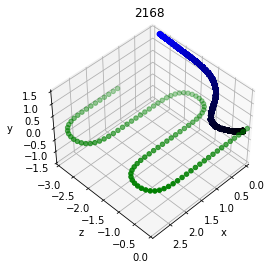

| eval  | E: 39 | S: 2168 | R: 194.9775
| train | E: 40 | S: 2168 | R: 108.6674 | D: 58.9 s | BR: 1.8763 | ALOSS: -27.9178 | CLOSS: 34.7189 | TLOSS: -3.4287 | TVAL: 0.5403 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 41 | S: 2220 | R: 108.2696 | D: 110.9 s | BR: 1.9862 | ALOSS: -27.4549 | CLOSS: 32.9599 | TLOSS: -3.5146 | TVAL: 0.5321 | AENT: -4.0000
| train | E: 42 | S: 2273 | R: 106.4927 | D: 64.7 s | BR: 2.0072 | ALOSS: -27.9771 | CLOSS: 37.5443 | TLOSS: -3.5845 | TVAL: 0.5240 | AENT: -4.0000
| train | E: 43 | S: 2326 | R: 4.8241 | D: 58.5 s | BR: 1.6894 | ALOSS: -29.1000 | CLOSS: 38.6904 | TLOSS: -3.6840 | TVAL: 0.5160 | AENT: -4.0000
| train | E: 44 | S: 2372 | R: 116.8443 | D: 51.2 s | BR: 1.3096 | ALOSS: -28.7098 | CLOSS: 42.2686 | TLOSS: -3.7617 | TVAL: 0.5086 | AENT: -4.0000
| train | E: 45 | S: 2426 | R: 183.8757 | D: 59.1 s | BR: 1.6417 | ALOSS: -29.5104 | CLOSS: 33.3589 | TLOSS: -3.8159 | TVAL: 0.5012 | AENT: -4.0000
| train | E: 46 | S: 2478 | R: 107.7770 | D: 60.8 s | BR: 2.0005 | ALOSS: -29.8399 | CLOSS: 40.2960 | TLOSS: -3.8692 | TVAL: 0.4936 | AENT: -4.0000
| train | E: 47 | S: 2511 | R: 115.5019 | D: 37.3 s | BR: 1.7749 | ALOSS: -30.1225 | CLOSS: 36.2668 | TLOSS: -3.9

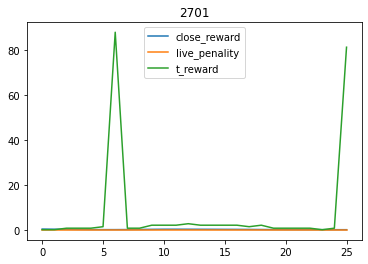

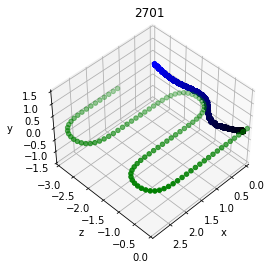

| eval  | E: 50 | S: 2701 | R: 197.4255
| train | E: 51 | S: 2701 | R: 186.4520 | D: 60.3 s | BR: 2.4523 | ALOSS: -33.0389 | CLOSS: 32.5213 | TLOSS: -4.1913 | TVAL: 0.4623 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 52 | S: 2754 | R: 112.9053 | D: 109.2 s | BR: 1.6869 | ALOSS: -32.3455 | CLOSS: 28.3842 | TLOSS: -4.1566 | TVAL: 0.4554 | AENT: -4.0000
| train | E: 53 | S: 2806 | R: 112.7374 | D: 64.3 s | BR: 1.7349 | ALOSS: -32.3076 | CLOSS: 32.6237 | TLOSS: -4.3603 | TVAL: 0.4486 | AENT: -4.0000
| train | E: 54 | S: 2859 | R: 108.9290 | D: 59.7 s | BR: 1.5570 | ALOSS: -31.9379 | CLOSS: 28.0884 | TLOSS: -4.4842 | TVAL: 0.4418 | AENT: -4.0000
| train | E: 55 | S: 2912 | R: 102.4747 | D: 70.4 s | BR: 1.6546 | ALOSS: -32.5445 | CLOSS: 30.1313 | TLOSS: -4.6135 | TVAL: 0.4350 | AENT: -4.0000
| train | E: 56 | S: 2964 | R: 111.4150 | D: 70.9 s | BR: 1.3837 | ALOSS: -33.0956 | CLOSS: 32.4669 | TLOSS: -4.5901 | TVAL: 0.4283 | AENT: -4.0000
| train | E: 57 | S: 3016 | R: 108.7631 | D: 63.8 s | BR: 1.7177 | ALOSS: -33.8697 | CLOSS: 29.8165 | TLOSS: -4.6161 | TVAL: 0.4219 | AENT: -4.0000
| train | E: 58 | S: 3065 | R: 116.2745 | D: 54.2 s | BR: 2.0254 | ALOSS: -33.8913 | CLOSS: 33.4313 | TLOSS: -4

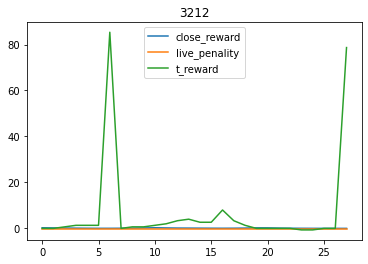

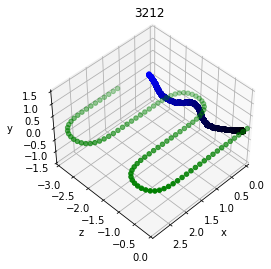

| eval  | E: 60 | S: 3212 | R: 197.6617
| train | E: 61 | S: 3212 | R: 202.3877 | D: 53.2 s | BR: 2.0943 | ALOSS: -36.1192 | CLOSS: 27.3274 | TLOSS: -4.9906 | TVAL: 0.3981 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 62 | S: 3266 | R: 189.6178 | D: 97.0 s | BR: 1.8281 | ALOSS: -35.0888 | CLOSS: 30.0459 | TLOSS: -5.1211 | TVAL: 0.3924 | AENT: -4.0000
| train | E: 63 | S: 3320 | R: 111.5320 | D: 59.7 s | BR: 1.5587 | ALOSS: -35.0876 | CLOSS: 31.3909 | TLOSS: -5.1041 | TVAL: 0.3862 | AENT: -4.0000
| train | E: 64 | S: 3367 | R: 118.2719 | D: 56.7 s | BR: 1.8906 | ALOSS: -36.2119 | CLOSS: 30.3869 | TLOSS: -5.0805 | TVAL: 0.3806 | AENT: -4.0000
| train | E: 65 | S: 3421 | R: 192.6845 | D: 58.8 s | BR: 1.8281 | ALOSS: -36.8344 | CLOSS: 44.0076 | TLOSS: -5.2049 | TVAL: 0.3751 | AENT: -4.0000
| train | E: 66 | S: 3473 | R: 107.6838 | D: 61.5 s | BR: 1.9642 | ALOSS: -37.5379 | CLOSS: 26.6684 | TLOSS: -5.1883 | TVAL: 0.3695 | AENT: -4.0000
| train | E: 67 | S: 3526 | R: 111.8849 | D: 57.3 s | BR: 1.8472 | ALOSS: -37.4131 | CLOSS: 31.0167 | TLOSS: -5.4324 | TVAL: 0.3640 | AENT: -4.0000
| train | E: 68 | S: 3578 | R: 109.5263 | D: 63.1 s | BR: 2.3184 | ALOSS: -38.0523 | CLOSS: 27.6892 | TLOSS: -5.

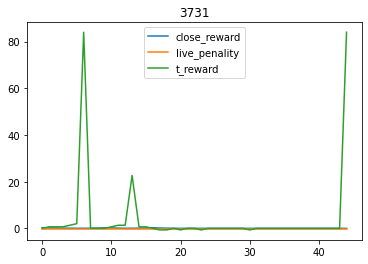

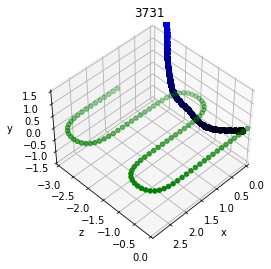

| eval  | E: 71 | S: 3731 | R: 195.3234
| train | E: 72 | S: 3731 | R: 189.2607 | D: 56.6 s | BR: 2.1694 | ALOSS: -39.6942 | CLOSS: 26.1820 | TLOSS: -5.6321 | TVAL: 0.3430 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 73 | S: 3784 | R: 110.3004 | D: 113.1 s | BR: 1.9455 | ALOSS: -40.0014 | CLOSS: 24.8087 | TLOSS: -5.4648 | TVAL: 0.3379 | AENT: -4.0000
| train | E: 74 | S: 3829 | R: 112.0583 | D: 50.5 s | BR: 2.4081 | ALOSS: -40.4841 | CLOSS: 29.2512 | TLOSS: -5.4104 | TVAL: 0.3334 | AENT: -4.0000
| train | E: 75 | S: 3880 | R: 194.3233 | D: 62.1 s | BR: 2.0433 | ALOSS: -39.8792 | CLOSS: 26.9955 | TLOSS: -5.6267 | TVAL: 0.3290 | AENT: -4.0000
| train | E: 76 | S: 3932 | R: 111.2167 | D: 56.7 s | BR: 1.9991 | ALOSS: -40.6261 | CLOSS: 25.3965 | TLOSS: -5.7728 | TVAL: 0.3242 | AENT: -4.0000
| train | E: 77 | S: 3965 | R: 119.1898 | D: 34.8 s | BR: 2.3990 | ALOSS: -40.8217 | CLOSS: 31.5304 | TLOSS: -5.6140 | TVAL: 0.3203 | AENT: -4.0000
| train | E: 78 | S: 4016 | R: 189.8286 | D: 60.4 s | BR: 1.4271 | ALOSS: -39.9657 | CLOSS: 34.2019 | TLOSS: -5.7595 | TVAL: 0.3166 | AENT: -4.0000
| train | E: 79 | S: 4068 | R: 110.5360 | D: 58.3 s | BR: 2.0820 | ALOSS: -42.6824 | CLOSS: 26.1135 | TLOSS: -5

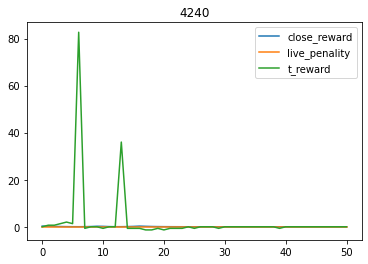

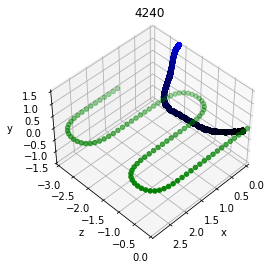

| eval  | E: 82 | S: 4240 | R: 110.2680
| train | E: 83 | S: 4240 | R: 112.1502 | D: 39.9 s | BR: 2.2332 | ALOSS: -42.3182 | CLOSS: 35.8709 | TLOSS: -5.8732 | TVAL: 0.2970 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 84 | S: 4267 | R: 205.7069 | D: 86.1 s | BR: 1.9248 | ALOSS: -41.8551 | CLOSS: 34.2012 | TLOSS: -5.7761 | TVAL: 0.2944 | AENT: -4.0000
| train | E: 85 | S: 4319 | R: 187.3345 | D: 60.8 s | BR: 1.7530 | ALOSS: -42.8921 | CLOSS: 26.1947 | TLOSS: -5.8181 | TVAL: 0.2913 | AENT: -4.0000
| train | E: 86 | S: 4348 | R: 117.2552 | D: 34.1 s | BR: 2.1381 | ALOSS: -44.7844 | CLOSS: 24.2284 | TLOSS: -5.8119 | TVAL: 0.2881 | AENT: -4.0000
| train | E: 87 | S: 4373 | R: 216.3492 | D: 28.0 s | BR: 1.5270 | ALOSS: -41.8718 | CLOSS: 26.0272 | TLOSS: -5.8759 | TVAL: 0.2861 | AENT: -4.0000
| train | E: 88 | S: 4399 | R: 187.0135 | D: 28.0 s | BR: 2.1010 | ALOSS: -43.7338 | CLOSS: 24.5206 | TLOSS: -5.8461 | TVAL: 0.2841 | AENT: -4.0000
| train | E: 89 | S: 4428 | R: 188.2652 | D: 35.8 s | BR: 2.2475 | ALOSS: -44.1604 | CLOSS: 31.3295 | TLOSS: -5.8001 | TVAL: 0.2820 | AENT: -4.0000
| train | E: 90 | S: 4455 | R: 193.1392 | D: 29.2 s | BR: 2.3729 | ALOSS: -43.4774 | CLOSS: 22.5081 | TLOSS: -5.

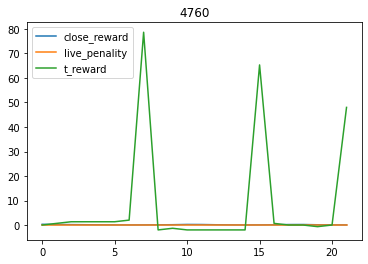

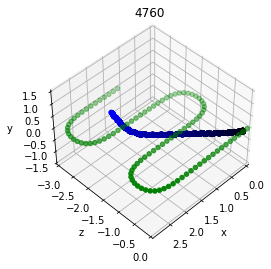

| eval  | E: 98 | S: 4760 | R: 186.9729
| train | E: 99 | S: 4760 | R: 167.6003 | D: 57.8 s | BR: 2.7129 | ALOSS: -46.9582 | CLOSS: 41.8646 | TLOSS: -5.9672 | TVAL: 0.2593 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 100 | S: 4788 | R: 141.2259 | D: 58.6 s | BR: 2.3723 | ALOSS: -47.0300 | CLOSS: 25.4054 | TLOSS: -5.9768 | TVAL: 0.2565 | AENT: -4.0000
| train | E: 101 | S: 4812 | R: 177.1912 | D: 26.3 s | BR: 3.1296 | ALOSS: -48.1453 | CLOSS: 39.6996 | TLOSS: -5.9378 | TVAL: 0.2548 | AENT: -4.0000
| train | E: 102 | S: 4840 | R: 195.9417 | D: 31.8 s | BR: 2.6778 | ALOSS: -49.9979 | CLOSS: 29.7115 | TLOSS: -5.8798 | TVAL: 0.2530 | AENT: -4.0000
| train | E: 103 | S: 4891 | R: 217.7295 | D: 56.9 s | BR: 2.6997 | ALOSS: -48.8140 | CLOSS: 27.7887 | TLOSS: -5.7323 | TVAL: 0.2505 | AENT: -4.0000
| train | E: 104 | S: 4935 | R: 143.0107 | D: 49.8 s | BR: 2.4661 | ALOSS: -49.2075 | CLOSS: 40.8800 | TLOSS: -5.9626 | TVAL: 0.2474 | AENT: -4.0000
| train | E: 105 | S: 4957 | R: 172.3240 | D: 24.9 s | BR: 2.8313 | ALOSS: -50.4195 | CLOSS: 39.5525 | TLOSS: -5.5632 | TVAL: 0.2453 | AENT: -4.0000
| train | E: 106 | S: 4983 | R: 203.5566 | D: 30.0 s | BR: 2.5019 | ALOSS: -50.6845 | CLOSS: 27.5687 | TLO

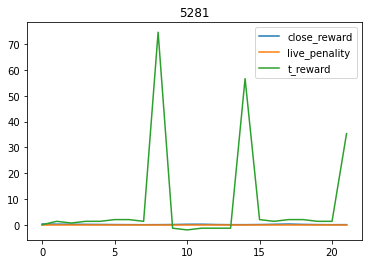

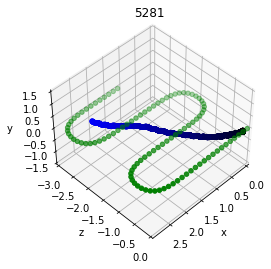

| eval  | E: 117 | S: 5281 | R: 179.8032
| train | E: 118 | S: 5281 | R: 182.2491 | D: 27.6 s | BR: 2.2309 | ALOSS: -52.9261 | CLOSS: 42.6004 | TLOSS: -5.7393 | TVAL: 0.2264 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 119 | S: 5304 | R: 187.1331 | D: 52.7 s | BR: 2.8918 | ALOSS: -52.2864 | CLOSS: 32.9444 | TLOSS: -5.9240 | TVAL: 0.2250 | AENT: -4.0000
| train | E: 120 | S: 5355 | R: 220.0295 | D: 59.7 s | BR: 2.7534 | ALOSS: -54.6580 | CLOSS: 57.9363 | TLOSS: -5.6097 | TVAL: 0.2230 | AENT: -4.0000
| train | E: 121 | S: 5378 | R: 137.1376 | D: 26.1 s | BR: 3.2119 | ALOSS: -56.5736 | CLOSS: 40.2064 | TLOSS: -5.6842 | TVAL: 0.2209 | AENT: -4.0000
| train | E: 122 | S: 5402 | R: 187.7144 | D: 27.1 s | BR: 3.1375 | ALOSS: -54.7252 | CLOSS: 36.6147 | TLOSS: -5.5038 | TVAL: 0.2196 | AENT: -4.0000
| train | E: 123 | S: 5431 | R: 198.5733 | D: 32.0 s | BR: 2.4800 | ALOSS: -53.1323 | CLOSS: 44.1711 | TLOSS: -5.2923 | TVAL: 0.2182 | AENT: -4.0000
| train | E: 124 | S: 5457 | R: 169.4246 | D: 28.5 s | BR: 2.4856 | ALOSS: -53.8656 | CLOSS: 51.7063 | TLOSS: -5.3451 | TVAL: 0.2168 | AENT: -4.0000
| train | E: 125 | S: 5483 | R: 196.6071 | D: 29.0 s | BR: 2.6351 | ALOSS: -53.1363 | CLOSS: 46.3472 | TLO

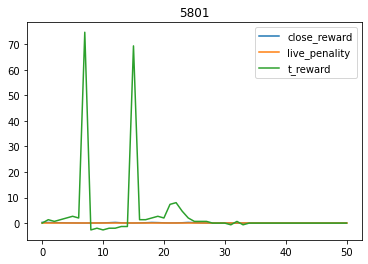

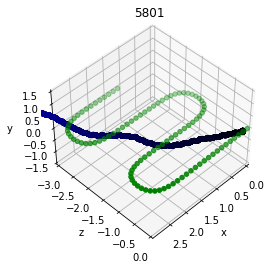

| eval  | E: 134 | S: 5801 | R: 171.1128
| train | E: 135 | S: 5801 | R: 143.7182 | D: 30.7 s | BR: 3.6970 | ALOSS: -58.4948 | CLOSS: 30.3039 | TLOSS: -5.1028 | TVAL: 0.1999 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 136 | S: 5829 | R: 215.7372 | D: 96.9 s | BR: 3.2890 | ALOSS: -58.0842 | CLOSS: 50.8116 | TLOSS: -5.0299 | TVAL: 0.1987 | AENT: -4.0000
| train | E: 137 | S: 5881 | R: 172.1355 | D: 58.4 s | BR: 3.5140 | ALOSS: -59.2453 | CLOSS: 29.5054 | TLOSS: -5.0976 | TVAL: 0.1969 | AENT: -4.0000
| train | E: 138 | S: 5932 | R: 171.8749 | D: 57.6 s | BR: 3.8079 | ALOSS: -59.8941 | CLOSS: 33.3910 | TLOSS: -5.2560 | TVAL: 0.1945 | AENT: -4.0000
| train | E: 139 | S: 5956 | R: 141.0949 | D: 30.4 s | BR: 3.0805 | ALOSS: -59.1057 | CLOSS: 72.4058 | TLOSS: -5.4012 | TVAL: 0.1928 | AENT: -4.0000
| train | E: 140 | S: 6007 | R: 214.5698 | D: 66.5 s | BR: 3.4076 | ALOSS: -59.9531 | CLOSS: 47.4330 | TLOSS: -5.2012 | TVAL: 0.1911 | AENT: -4.0000
| train | E: 141 | S: 6031 | R: 143.5870 | D: 27.5 s | BR: 3.5604 | ALOSS: -62.1229 | CLOSS: 35.5681 | TLOSS: -5.1478 | TVAL: 0.1894 | AENT: -4.0000
| train | E: 142 | S: 6054 | R: 178.4422 | D: 26.6 s | BR: 3.5331 | ALOSS: -59.5904 | CLOSS: 56.9044 | TLO

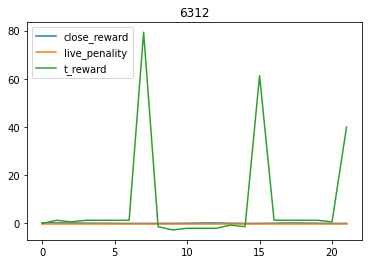

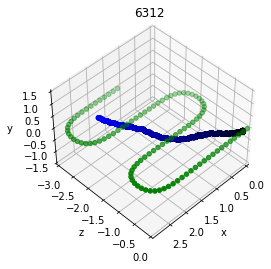

| eval  | E: 149 | S: 6312 | R: 182.3000
| train | E: 150 | S: 6312 | R: 213.7476 | D: 58.6 s | BR: 3.2194 | ALOSS: -62.7807 | CLOSS: 60.7784 | TLOSS: -4.6585 | TVAL: 0.1781 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 151 | S: 6337 | R: 142.3281 | D: 55.0 s | BR: 3.5139 | ALOSS: -64.9967 | CLOSS: 43.7308 | TLOSS: -5.1053 | TVAL: 0.1766 | AENT: -4.0000
| train | E: 152 | S: 6360 | R: 184.8962 | D: 26.3 s | BR: 3.0221 | ALOSS: -66.9662 | CLOSS: 47.6171 | TLOSS: -5.2457 | TVAL: 0.1756 | AENT: -4.0000
| train | E: 153 | S: 6387 | R: 180.7677 | D: 29.9 s | BR: 2.7158 | ALOSS: -65.4454 | CLOSS: 67.8957 | TLOSS: -5.0606 | TVAL: 0.1746 | AENT: -4.0000
| train | E: 154 | S: 6438 | R: 207.0515 | D: 61.6 s | BR: 3.6622 | ALOSS: -64.2104 | CLOSS: 50.1854 | TLOSS: -4.6003 | TVAL: 0.1731 | AENT: -4.0000
| train | E: 155 | S: 6489 | R: 169.0656 | D: 57.2 s | BR: 3.5199 | ALOSS: -64.4477 | CLOSS: 55.1053 | TLOSS: -5.0039 | TVAL: 0.1711 | AENT: -4.0000
| train | E: 156 | S: 6540 | R: 169.7538 | D: 58.0 s | BR: 3.3428 | ALOSS: -66.1493 | CLOSS: 38.0649 | TLOSS: -4.1422 | TVAL: 0.1692 | AENT: -4.0000
| train | E: 157 | S: 6561 | R: 142.2662 | D: 24.4 s | BR: 3.0138 | ALOSS: -62.1613 | CLOSS: 53.4520 | TLO

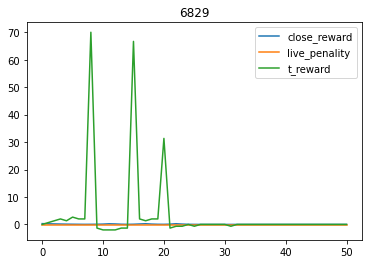

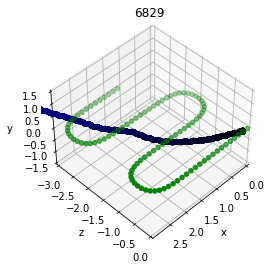

| eval  | E: 165 | S: 6829 | R: 171.2048
| train | E: 166 | S: 6829 | R: 193.8708 | D: 28.7 s | BR: 3.0250 | ALOSS: -67.5025 | CLOSS: 49.4420 | TLOSS: -3.9632 | TVAL: 0.1587 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 167 | S: 6880 | R: 211.1306 | D: 122.4 s | BR: 3.3523 | ALOSS: -66.9895 | CLOSS: 30.4247 | TLOSS: -4.2315 | TVAL: 0.1575 | AENT: -4.0000
| train | E: 168 | S: 6905 | R: 144.9607 | D: 30.5 s | BR: 3.5188 | ALOSS: -67.9143 | CLOSS: 65.8076 | TLOSS: -4.1007 | TVAL: 0.1563 | AENT: -4.0000
| train | E: 169 | S: 6936 | R: 214.6241 | D: 37.9 s | BR: 3.3187 | ALOSS: -67.0556 | CLOSS: 33.7988 | TLOSS: -4.0492 | TVAL: 0.1554 | AENT: -4.0000
| train | E: 170 | S: 6963 | R: 178.6055 | D: 30.3 s | BR: 4.2944 | ALOSS: -70.9405 | CLOSS: 65.9402 | TLOSS: -3.7521 | TVAL: 0.1545 | AENT: -4.0000
| train | E: 171 | S: 6985 | R: 146.3245 | D: 27.6 s | BR: 3.2627 | ALOSS: -68.8829 | CLOSS: 29.7080 | TLOSS: -3.8508 | TVAL: 0.1538 | AENT: -4.0000
| train | E: 172 | S: 7009 | R: 180.5452 | D: 27.7 s | BR: 3.4983 | ALOSS: -68.6823 | CLOSS: 88.0790 | TLOSS: -3.9505 | TVAL: 0.1531 | AENT: -4.0000
| train | E: 173 | S: 7060 | R: 208.8930 | D: 61.6 s | BR: 2.8906 | ALOSS: -67.6823 | CLOSS: 51.2339 | TL

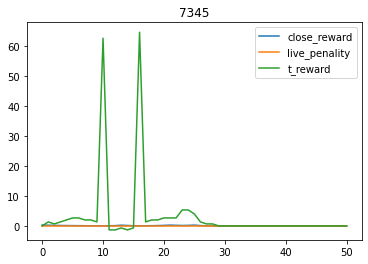

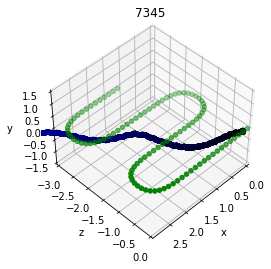

| eval  | E: 183 | S: 7345 | R: 167.1779
| train | E: 184 | S: 7345 | R: 206.6896 | D: 58.5 s | BR: 3.6681 | ALOSS: -69.9343 | CLOSS: 62.1611 | TLOSS: -3.9224 | TVAL: 0.1440 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 185 | S: 7396 | R: 167.4799 | D: 123.7 s | BR: 3.9197 | ALOSS: -71.7175 | CLOSS: 54.1571 | TLOSS: -4.1509 | TVAL: 0.1424 | AENT: -4.0000
| train | E: 186 | S: 7422 | R: 147.0391 | D: 33.1 s | BR: 3.6374 | ALOSS: -70.8754 | CLOSS: 43.1924 | TLOSS: -4.1766 | TVAL: 0.1412 | AENT: -4.0000
| train | E: 187 | S: 7473 | R: 203.5157 | D: 58.9 s | BR: 4.1647 | ALOSS: -72.5230 | CLOSS: 40.5066 | TLOSS: -4.0681 | TVAL: 0.1400 | AENT: -4.0000
| train | E: 188 | S: 7501 | R: 178.0686 | D: 35.2 s | BR: 3.8393 | ALOSS: -71.0398 | CLOSS: 35.0669 | TLOSS: -3.7464 | TVAL: 0.1388 | AENT: -4.0000
| train | E: 189 | S: 7526 | R: 180.2902 | D: 28.8 s | BR: 3.1356 | ALOSS: -70.8129 | CLOSS: 43.4388 | TLOSS: -3.6905 | TVAL: 0.1381 | AENT: -4.0000
| train | E: 190 | S: 7555 | R: 143.1422 | D: 33.1 s | BR: 3.5235 | ALOSS: -69.6109 | CLOSS: 18.3484 | TLOSS: -3.5291 | TVAL: 0.1373 | AENT: -4.0000
| train | E: 191 | S: 7606 | R: 209.2543 | D: 56.6 s | BR: 3.9418 | ALOSS: -74.2491 | CLOSS: 48.6384 | TL

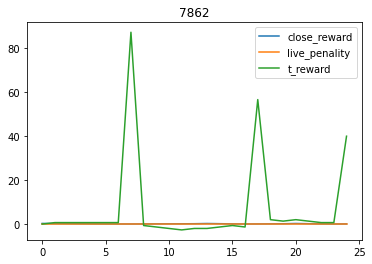

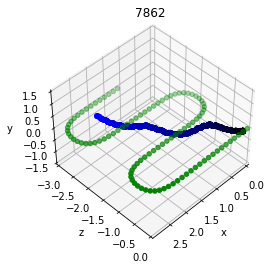

| eval  | E: 198 | S: 7862 | R: 182.3782
| train | E: 199 | S: 7862 | R: 143.6439 | D: 28.2 s | BR: 3.4920 | ALOSS: -74.0808 | CLOSS: 28.9431 | TLOSS: -3.8664 | TVAL: 0.1287 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 200 | S: 7913 | R: 213.6928 | D: 89.0 s | BR: 4.1069 | ALOSS: -73.8997 | CLOSS: 37.6259 | TLOSS: -3.9492 | TVAL: 0.1276 | AENT: -4.0000
| train | E: 201 | S: 7939 | R: 145.8103 | D: 31.0 s | BR: 3.3791 | ALOSS: -73.3409 | CLOSS: 39.8640 | TLOSS: -3.8834 | TVAL: 0.1265 | AENT: -4.0000
| train | E: 202 | S: 7990 | R: 209.0483 | D: 58.9 s | BR: 3.5704 | ALOSS: -73.6587 | CLOSS: 29.7128 | TLOSS: -3.7292 | TVAL: 0.1254 | AENT: -4.0000
| train | E: 203 | S: 8018 | R: 143.1768 | D: 31.9 s | BR: 3.5474 | ALOSS: -74.2962 | CLOSS: 32.8412 | TLOSS: -4.4010 | TVAL: 0.1243 | AENT: -4.0000
| train | E: 204 | S: 8042 | R: 185.7206 | D: 26.6 s | BR: 4.0739 | ALOSS: -72.6082 | CLOSS: 38.8866 | TLOSS: -4.1231 | TVAL: 0.1235 | AENT: -4.0000
| train | E: 205 | S: 8067 | R: 177.1075 | D: 28.0 s | BR: 3.7265 | ALOSS: -74.6807 | CLOSS: 44.4025 | TLOSS: -3.9051 | TVAL: 0.1228 | AENT: -4.0000
| train | E: 206 | S: 8090 | R: 179.1799 | D: 26.2 s | BR: 3.7543 | ALOSS: -76.9565 | CLOSS: 34.6922 | TLO

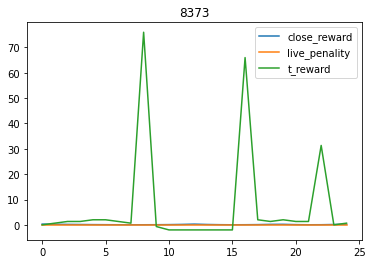

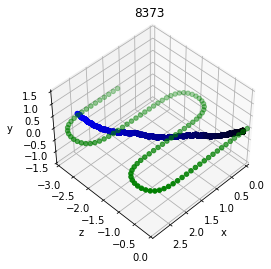

| eval  | E: 213 | S: 8373 | R: 179.2256
| train | E: 214 | S: 8373 | R: 174.9902 | D: 57.3 s | BR: 3.7147 | ALOSS: -76.3217 | CLOSS: 40.3610 | TLOSS: -3.3501 | TVAL: 0.1153 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 215 | S: 8424 | R: 174.7609 | D: 88.2 s | BR: 4.2009 | ALOSS: -76.9433 | CLOSS: 43.2159 | TLOSS: -3.2118 | TVAL: 0.1141 | AENT: -4.0000
| train | E: 216 | S: 8451 | R: 143.9014 | D: 30.4 s | BR: 4.1262 | ALOSS: -77.0615 | CLOSS: 53.2186 | TLOSS: -2.7289 | TVAL: 0.1132 | AENT: -4.0000
| train | E: 217 | S: 8482 | R: 215.8244 | D: 38.6 s | BR: 3.9870 | ALOSS: -77.4885 | CLOSS: 32.0703 | TLOSS: -2.6947 | TVAL: 0.1127 | AENT: -4.0000
| train | E: 218 | S: 8509 | R: 146.7759 | D: 32.9 s | BR: 4.4985 | ALOSS: -77.8994 | CLOSS: 38.4044 | TLOSS: -3.3111 | TVAL: 0.1121 | AENT: -4.0000
| train | E: 219 | S: 8539 | R: 212.3360 | D: 32.5 s | BR: 4.1818 | ALOSS: -78.7048 | CLOSS: 36.7960 | TLOSS: -2.7116 | TVAL: 0.1115 | AENT: -4.0000
| train | E: 220 | S: 8578 | R: 144.9314 | D: 48.9 s | BR: 3.8025 | ALOSS: -77.9511 | CLOSS: 47.7692 | TLOSS: -3.0634 | TVAL: 0.1108 | AENT: -4.0000
| train | E: 221 | S: 8606 | R: 179.5086 | D: 32.6 s | BR: 3.9391 | ALOSS: -77.6490 | CLOSS: 50.8323 | TLO

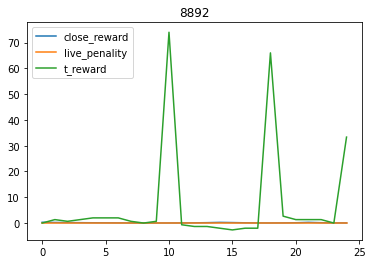

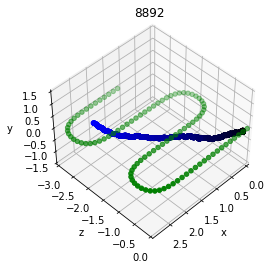

| eval  | E: 230 | S: 8892 | R: 178.9197
| train | E: 231 | S: 8892 | R: 147.5597 | D: 28.2 s | BR: 3.6269 | ALOSS: -77.0722 | CLOSS: 52.0729 | TLOSS: -2.9478 | TVAL: 0.1038 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 232 | S: 8919 | R: 177.5334 | D: 56.5 s | BR: 4.6947 | ALOSS: -79.4930 | CLOSS: 29.0500 | TLOSS: -3.0853 | TVAL: 0.1033 | AENT: -4.0000
| train | E: 233 | S: 8951 | R: 213.4035 | D: 37.5 s | BR: 4.3541 | ALOSS: -80.4447 | CLOSS: 35.3087 | TLOSS: -2.8239 | TVAL: 0.1027 | AENT: -4.0000
| train | E: 234 | S: 8994 | R: 177.3680 | D: 48.1 s | BR: 4.3284 | ALOSS: -80.8666 | CLOSS: 38.2889 | TLOSS: -3.1066 | TVAL: 0.1019 | AENT: -4.0000
| train | E: 235 | S: 9028 | R: 178.2880 | D: 36.7 s | BR: 4.1581 | ALOSS: -80.5224 | CLOSS: 25.4014 | TLOSS: -3.2481 | TVAL: 0.1011 | AENT: -4.0000
| train | E: 236 | S: 9062 | R: 149.4240 | D: 36.5 s | BR: 3.5232 | ALOSS: -78.9945 | CLOSS: 37.4303 | TLOSS: -3.6649 | TVAL: 0.1003 | AENT: -4.0000
| train | E: 237 | S: 9093 | R: 211.5984 | D: 34.7 s | BR: 4.2557 | ALOSS: -78.9461 | CLOSS: 33.4773 | TLOSS: -3.5214 | TVAL: 0.0995 | AENT: -4.0000
| train | E: 238 | S: 9125 | R: 179.3643 | D: 37.4 s | BR: 4.3754 | ALOSS: -80.4204 | CLOSS: 27.3177 | TLO

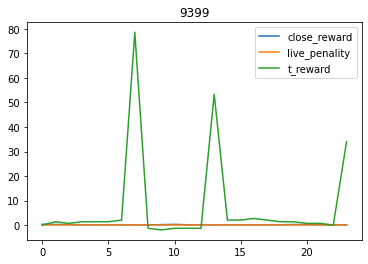

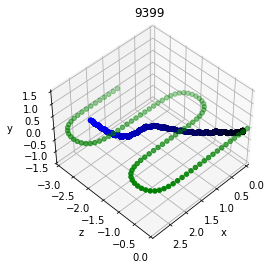

| eval  | E: 247 | S: 9399 | R: 179.4692
| train | E: 248 | S: 9399 | R: 217.0952 | D: 33.3 s | BR: 4.0300 | ALOSS: -78.8376 | CLOSS: 39.7960 | TLOSS: -3.1525 | TVAL: 0.0929 | AENT: -4.0000


/root/anaconda3/envs/pytorch_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


| train | E: 249 | S: 9425 | R: 180.3739 | D: 57.8 s | BR: 3.9358 | ALOSS: -81.1592 | CLOSS: 33.5664 | TLOSS: -3.1799 | TVAL: 0.0924 | AENT: -4.0000
| train | E: 250 | S: 9449 | R: 145.8393 | D: 26.9 s | BR: 4.1833 | ALOSS: -83.8437 | CLOSS: 21.0460 | TLOSS: -3.1737 | TVAL: 0.0919 | AENT: -4.0000
| train | E: 251 | S: 9473 | R: 175.5442 | D: 28.3 s | BR: 3.6094 | ALOSS: -81.0173 | CLOSS: 48.3274 | TLOSS: -3.7238 | TVAL: 0.0914 | AENT: -4.0000
| train | E: 252 | S: 9501 | R: 218.9256 | D: 32.1 s | BR: 3.0296 | ALOSS: -79.2597 | CLOSS: 52.8220 | TLOSS: -3.3749 | TVAL: 0.0908 | AENT: -4.0000
| train | E: 253 | S: 9530 | R: 179.7986 | D: 35.0 s | BR: 4.4774 | ALOSS: -83.1903 | CLOSS: 31.8853 | TLOSS: -3.1210 | TVAL: 0.0901 | AENT: -4.0000
| train | E: 254 | S: 9557 | R: 146.2725 | D: 30.6 s | BR: 4.1929 | ALOSS: -78.1615 | CLOSS: 48.2309 | TLOSS: -3.4134 | TVAL: 0.0895 | AENT: -4.0000
| train | E: 255 | S: 9582 | R: 176.4482 | D: 30.3 s | BR: 4.2414 | ALOSS: -81.6988 | CLOSS: 46.5423 | TLO

In [ ]:
while step < num_train_steps:
    samples = collect_traj()
    for sample in samples:
        obs,action,next_obs,reward,done = sample
        if done:
            logger.log('train/duration',time.time() - start_time, step)
            start_time = time.time()
            # evaluate hl_agent periodically
            if step >=next_eval_steps:
                # save model
                hl_agent.save(model_folder+"steps_{0}".format(step))
                logger.log('eval/episode', episode, step)
                next_eval_steps = step+eval_frequency
                evaluate()
            logger.log('train/episode_reward', episode_reward,step)
            episode_reward = 0
            episode += 1
            logger.log('train/episode', episode, step)
            logger.dump(step, save=True,ty='train')
        # run training update
        log_data = hl_agent.train(gradient_steps,batch_size)
        logger.log_data(log_data,step)
        done = float(done)
        episode_reward += reward
        step += 1
        hl_agent.replay_buffer.add(obs, action, reward, next_obs, done)

In [ ]:
torch.save({'buffer':agent.replay_buffer},model_folder+'buffer')
torch.save({'actor':agent.actor.state_dict()},model_folder+'actor')
agent.save(model_folder+'model')

In [ ]:
agent.replay_buffer.full

In [ ]:
model_folder+'model'

## Evaluation and Test

In [ ]:
evaluate_save_fluid=False
evaluate_save_data=True

In [ ]:
def evaluate_traj(theta,dist):
        print("Evaluating episode  ...."+str(theta))
        obs = env.reset()
        env.set_task(theta,dist)
        ref_line = fl.debugLine()
        ref_line.vertices = [
                    env.path_start*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
                ]
        fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")
        agent.reset()
        done = False
        episode_reward = 0
        infos = []
        while not done:
            with utils.eval_mode(agent):
                action = agent.act(obs, sample=False)
            if evaluate_save_data:
                obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
            else:
                obs, reward, done, info = env.step(action)
            infos.append(info)
            # video_recorder.record(env)
            episode_reward += reward
        print(episode_reward)
#         plot_infos(infos,title=str(theta))
        env.plot3d(title=str(theta))

In [ ]:
!./clean_visdata.sh
evaluate_traj(3.14,0.01)

In [ ]:
ref_line = fl.debugLine()
ref_line.vertices = [
            env.path_start*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
        ]
fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")

In [ ]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''
    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
setattr(Axes3D,'arrow3D',_arrow3D)

In [ ]:
%matplotlib notebook

In [ ]:
from gym_fish.envs.py_util import flare_util
from gym_fish.envs.lib import pyflare as fl

In [ ]:
# fluid_json = json_folder+'fluid_param_0.5.json'
# rigid_json = json_folder+'rigids_4_30_test.json'
# frame_skip = 100
from gym_fish.envs import FishEnv
env=gym.make('fish-v0', 
                  gpuId=gpuId,
                        couple_mode=couple_mode,frame_skip=frame_skip,radius=radius,
                       theta=theta,action_max=action_max,random_vel=random_vel,max_time=max_time,
                       fluid_json=fluid_json,wp=wp,wr=wr,wa=wa,live_penality =live_penality,
                       rigid_json=rigid_json,vel_theta = vel_theta,
                       done_dist=done_dist,dist_distri_param=dist_distri_param,use_com=use_com
               
                   )
env.plot3d()

In [ ]:
### test generalization to sequence goals
path = flare_util.path_data()
path.from_json(str(Path("./py_data/jsons/paths/path_ss.json").resolve()))
traj  =  path.trajectory
paths_by_t= np.array([ traj.getPose(t).getPosition()  for t in np.arange(0.0,1.0,1.0/100) ])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = paths_by_t[:,0]
Y = paths_by_t[:,1]
Z = paths_by_t[:,2]
ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_z - max_range, mid_z + max_range)
ax.set_zlim(mid_y - max_range, mid_y + max_range)
plt.show()

In [ ]:
def plot_env(env,ax):
    ax.clear()
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_z - max_range, mid_z + max_range)
    ax.set_zlim(mid_y - max_range, mid_y + max_range)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.view_init(elev=45,azim=45)#改变绘制图像的视角,即相机的位置,azim沿着z轴旋转，elev沿着y轴
    dxyz = env.goal_pos-env.body_xyz
    fwd = env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()
    right = env.rigid_data.skeletons[0].dynamics.getBaseLinkRight()
    up = env.rigid_data.skeletons[0].dynamics.getBaseLinkUp()
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],fwd[0],fwd[2],fwd[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='red')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],right[0],right[2],right[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='green')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],up[0],up[2],up[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='blue')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],dxyz[0],dxyz[2],dxyz[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='yellow',)
    ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
    fig.canvas.draw()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(traj, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
env.training = False
# skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
# skeleton_dynamics.getJoint("head").setVelocity(0,0)
# skeleton_dynamics.getJoint("head").setVelocity(1,0)
# joint_list =['spine','spine01','spine02','spine03']
# for jnt_name in joint_list:
#     skeleton_dynamics.getJoint(jnt_name).setPosition(0,0)
#     skeleton_dynamics.getJoint(jnt_name).setVelocity(0,0)


# skeleton_dynamics.update()

t = 0.001
dt = 0.05
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()
goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 
env.set_task(goal_pos,0.3)


env.set_datapath(store_folder+'/data/')
# skeleton_dynamics.setHead(path_position_begin,path_orientation_begin)



env.goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 
env.path_start  = env.body_xyz 
env.path_dir = env.goal_pos-env.path_start
env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
actions= []
observations = []
vels = []
while True:
    if env.rigid_data.rigidWorld.time>50 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break 
    obs = env._get_obs()
    observations.append(obs)
    action = agent.predict(obs, deterministic=True)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    env.step(action,save_objects=True,save_fluid=False)
    
    rela_vec_to_goal = env.goal_pos-env.body_xyz
    dist_to_path = np.linalg.norm(rela_vec_to_goal-env.path_dir*np.dot(rela_vec_to_goal,env.path_dir))
    env.proj_pt_world = env.goal_pos-env.path_dir*np.dot(rela_vec_to_goal,env.path_dir)
    if np.linalg.norm(env.body_xyz-env.goal_pos)<0.3:
        t= t+dt
        env.init_pos  = env.body_xyz 
        env.set_task( traj.getPose(t).getPosition(),0.3)
    plot_env(env,ax)
plt.close(fig)


In [ ]:
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),vels)
# plt.show()
plt.figure()
plt.plot(np.arange(0,len(actions),1),actions)
plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
# plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(observations),1),np.array(observations))
# plt.show()
plt.figure()
plt.plot(np.arange(0,len(actions),1),[ 0.1* np.sum(np.abs(a)**0.5) for a in actions])
plt.show()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(env.path_data.trajectory, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
dones = False
infos = []
reward = 0
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(0,0)
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(1,0)

t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()

env.init_pos = path_position_begin
env.set_theta(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
    

actions= []
observations = []
vels = []
while not dones:
    obs = env._get_obs()
    observations.append(obs)
    if env.rigid_data.rigidWorld.time>20:
#     if env.rigid_data.rigidWorld.time>100 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break
    with utils.eval_mode(ws.agent):
        action = ws.agent.act(obs, sample=False)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    _,_,_,_=env.stepSave(action,save_objects=False,save_fluid=False)
    env.goal_pos = env.body_xyz+env.goal_dir*2.0
    plot_env(env,ax)
plt.close(fig)


In [ ]:
plt.figure()
plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
plt.show()